In [6]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import plot
import predict

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


# load the model

In [7]:
# load experiment 12 (to find the boundary where the log-likelihood begins to drop)
e01 = exp.load('disentanglement_01', experiment_location='experiments', datadir='Mdata')

# load the 'exps/activity.txt' file
class TrialLosses:
    def __init__(self, activity):
        self.activity = activity
        self.losses = {}
        self.sparsenesses = {}

    def add_epoch(self, epoch):
        self.losses[epoch] = {}

    def add_loss(self, loss, batch, epoch):
        try:
            self.losses[epoch][batch].append(loss)
        except:
            self.losses[epoch] = {batch: [loss]}

    def add_sparseness(self, sparseness, batch, epoch):
        try:
            self.sparsenesses[epoch][batch].append(sparseness)
        except:
            self.sparsenesses[epoch] = {batch: [sparseness]}

    def get_losses(self):
        batch_losses = []
        for epoch in self.losses:
            for batch in self.losses[epoch]:
                batch_loss = np.mean(self.losses[epoch][batch])
                batch_losses.append(batch_loss)
        return batch_losses

    def get_sparsenesses(self):
        batch_sparsenesses = []
        for epoch in self.sparsenesses:
            for batch in self.sparsenesses[epoch]:
                batch_sparseness = np.mean(self.sparsenesses[epoch][batch])
                batch_sparsenesses.append(batch_sparseness)
        return batch_sparsenesses

    def __str__(self):
        return self.activity

trial_losseses = []

with open('exps/activity.txt', 'r') as f:
    trial_losses = None
    batch = None
    for linestr in f:
        line = linestr.split()
        if line[0] == 'run_activity':
            if trial_losses is not None: # save the previous trial
                trial_losseses.append(trial_losses)
            activity = line[1]
            trial_losses = TrialLosses(activity)
            print(activity)
        elif line[0] == 'epoch':
            epoch = int(line[1])
            trial_losses.add_epoch(epoch)
        elif line[0] == 'batch':
            batch = int(line[1])
        elif line[0] == 'loss':
            loss = float(line[1])
            trial_losses.add_loss(loss, batch, epoch)
        elif line[0] == 'sparseness':
            sparseness = float(line[1])
            trial_losses.add_sparseness(sparseness, batch, epoch)
    trial_losseses.append(trial_losses) # add the last trial

e01.trials_df

0.0001
5e-05
0.0001
0.0001
0.0001
0.0001
1e-05
1e-06
1e-07
0.0


,null_adjusted_LL,num_filters,num_inh_percent,expt,kernel_widths,kernel_heights,copy_weights,freeze_weights,include_MUs,is_multiexp,...,modelstr,trial_idx,run,activity,d2xt,center,bcs,name,trial,mean_LLs
0,True,"16,8,8",0.5,expt01+expt02+expt03+expt04+expt05+expt06+expt...,"21,11,5","3,3,3",False,False,False,False,...,cnim_scaffold,0,0,1.000000e-04,0.01,0.01,{'d2xt': 1},cnim_scaffold0.0,<experiment.Trial object at 0x7fc762789f70>,0.116485
0,True,"16,8,8",0.5,expt01+expt02+expt03+expt04+expt05+expt06+expt...,"21,11,5","3,3,3",False,False,False,False,...,cnim_scaffold,1,0,1.000000e-05,0.01,0.01,{'d2xt': 1},cnim_scaffold1.0,<experiment.Trial object at 0x7fc7626d1370>,0.135708
0,True,"16,8,8",0.5,expt01+expt02+expt03+expt04+expt05+expt06+expt...,"21,11,5","3,3,3",False,False,False,False,...,cnim_scaffold,2,0,1.000000e-06,0.01,0.01,{'d2xt': 1},cnim_scaffold2.0,<experiment.Trial object at 0x7fc76ef1b0d0>,0.175315
0,True,"16,8,8",0.5,expt01+expt02+expt03+expt04+expt05+expt06+expt...,"21,11,5","3,3,3",False,False,False,False,...,cnim_scaffold,3,0,1.000000e-07,0.01,0.01,{'d2xt': 1},cnim_scaffold3.0,<experiment.Trial object at 0x7fc762631070>,0.178991
0,True,"16,8,8",0.5,expt01+expt02+expt03+expt04+expt05+expt06+expt...,"21,11,5","3,3,3",False,False,False,False,...,cnim_scaffold,4,0,0.000000e+00,0.01,0.01,{'d2xt': 1},cnim_scaffold4.0,<experiment.Trial object at 0x7fc7626c8df0>,0.178797


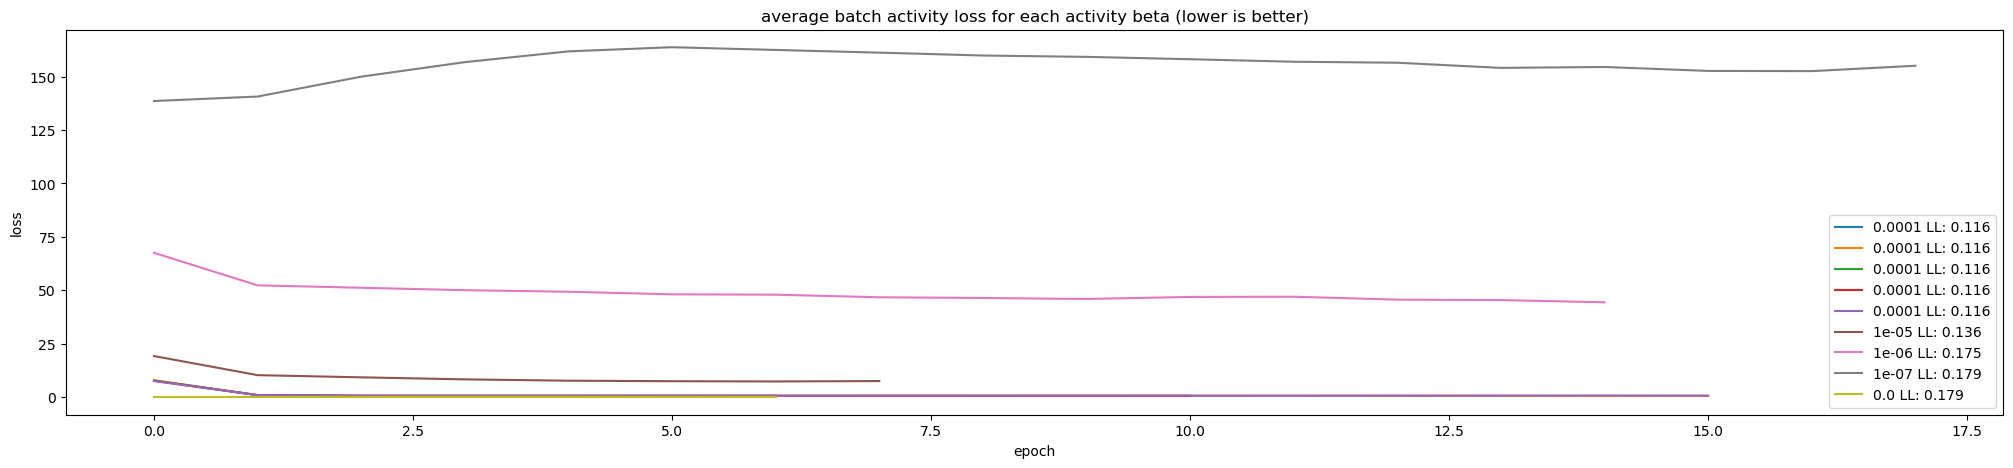

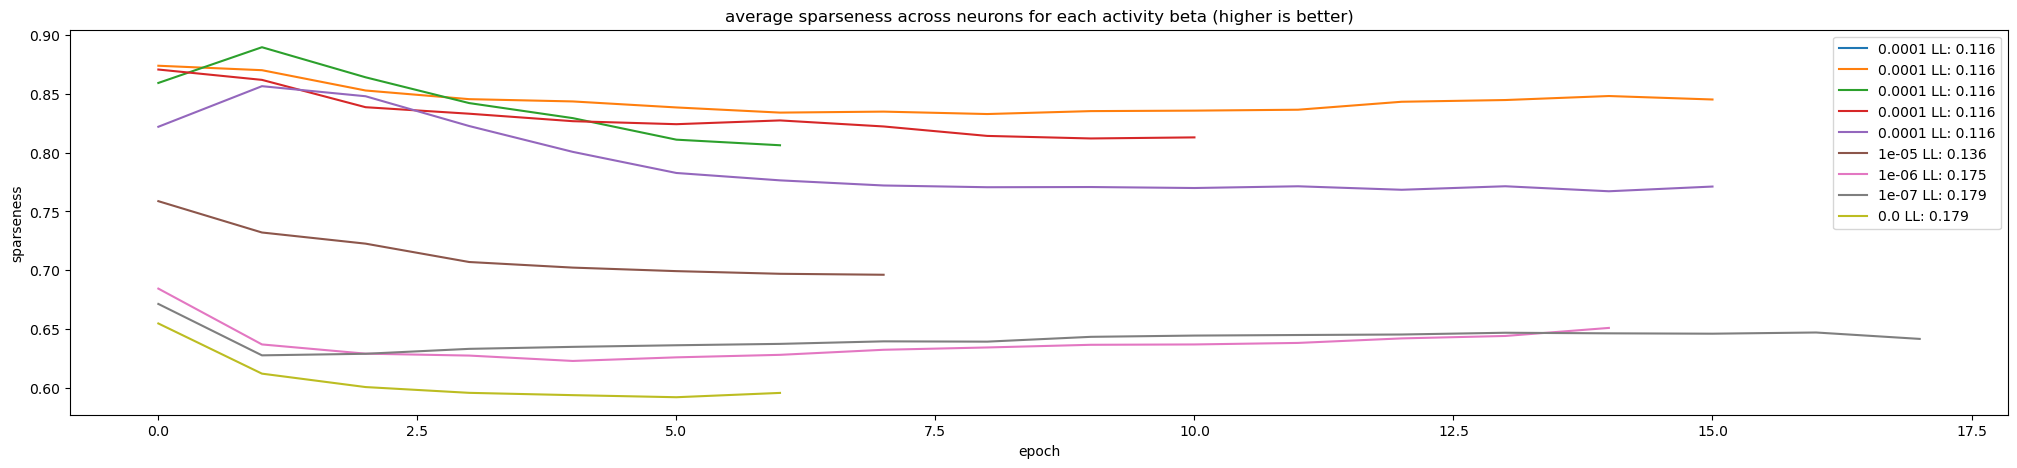

In [9]:
fig = plt.figure(figsize=(25,5))
for trial_losses in trial_losseses:
    trial = e01.trials_where(activity=float(trial_losses.activity))
    if len(trial) == 0:
        continue
    ll = np.mean(trial[0].LLs)
    if trial_losses.activity != '0.0':
        plt.plot(np.array(trial_losses.get_losses())/float(trial_losses.activity), label=trial_losses.activity + ' LL: ' + '{:.3f}'.format(ll))
    else:
        plt.plot(np.array(trial_losses.get_losses()), label=trial_losses.activity + ' LL: ' + '{:.3f}'.format(ll))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('average batch activity loss for each activity beta (lower is better)')
plt.legend()
plt.show()

fig = plt.figure(figsize=(25,5))
for trial_losses in trial_losseses:
    trial = e01.trials_where(activity=float(trial_losses.activity))
    if len(trial) == 0:
        continue
    ll = np.mean(trial[0].LLs)
    plt.plot(trial_losses.get_sparsenesses(), label=trial_losses.activity + ' LL: ' + '{:.3f}'.format(ll))
plt.xlabel('epoch')
plt.ylabel('sparseness')
plt.title('average sparseness across neurons for each activity beta (higher is better)')
plt.legend()
plt.show()

In [10]:
# load model with less regularization
trial_more_reg = e01.trials_where(activity=1e-5)[0]
# load model with more regularization
trial_less_reg = e01.trials_where(activity=1e-6)[0]
print('less', trial_less_reg.trial_params['activity'], 'more', trial_more_reg.trial_params['activity'])
trial_less_reg.model.networks_by_name['readout'].layers[0].weights.shape

less 1e-06 more 1e-05


(32, 36, 72)

# plot the readout weights side by side

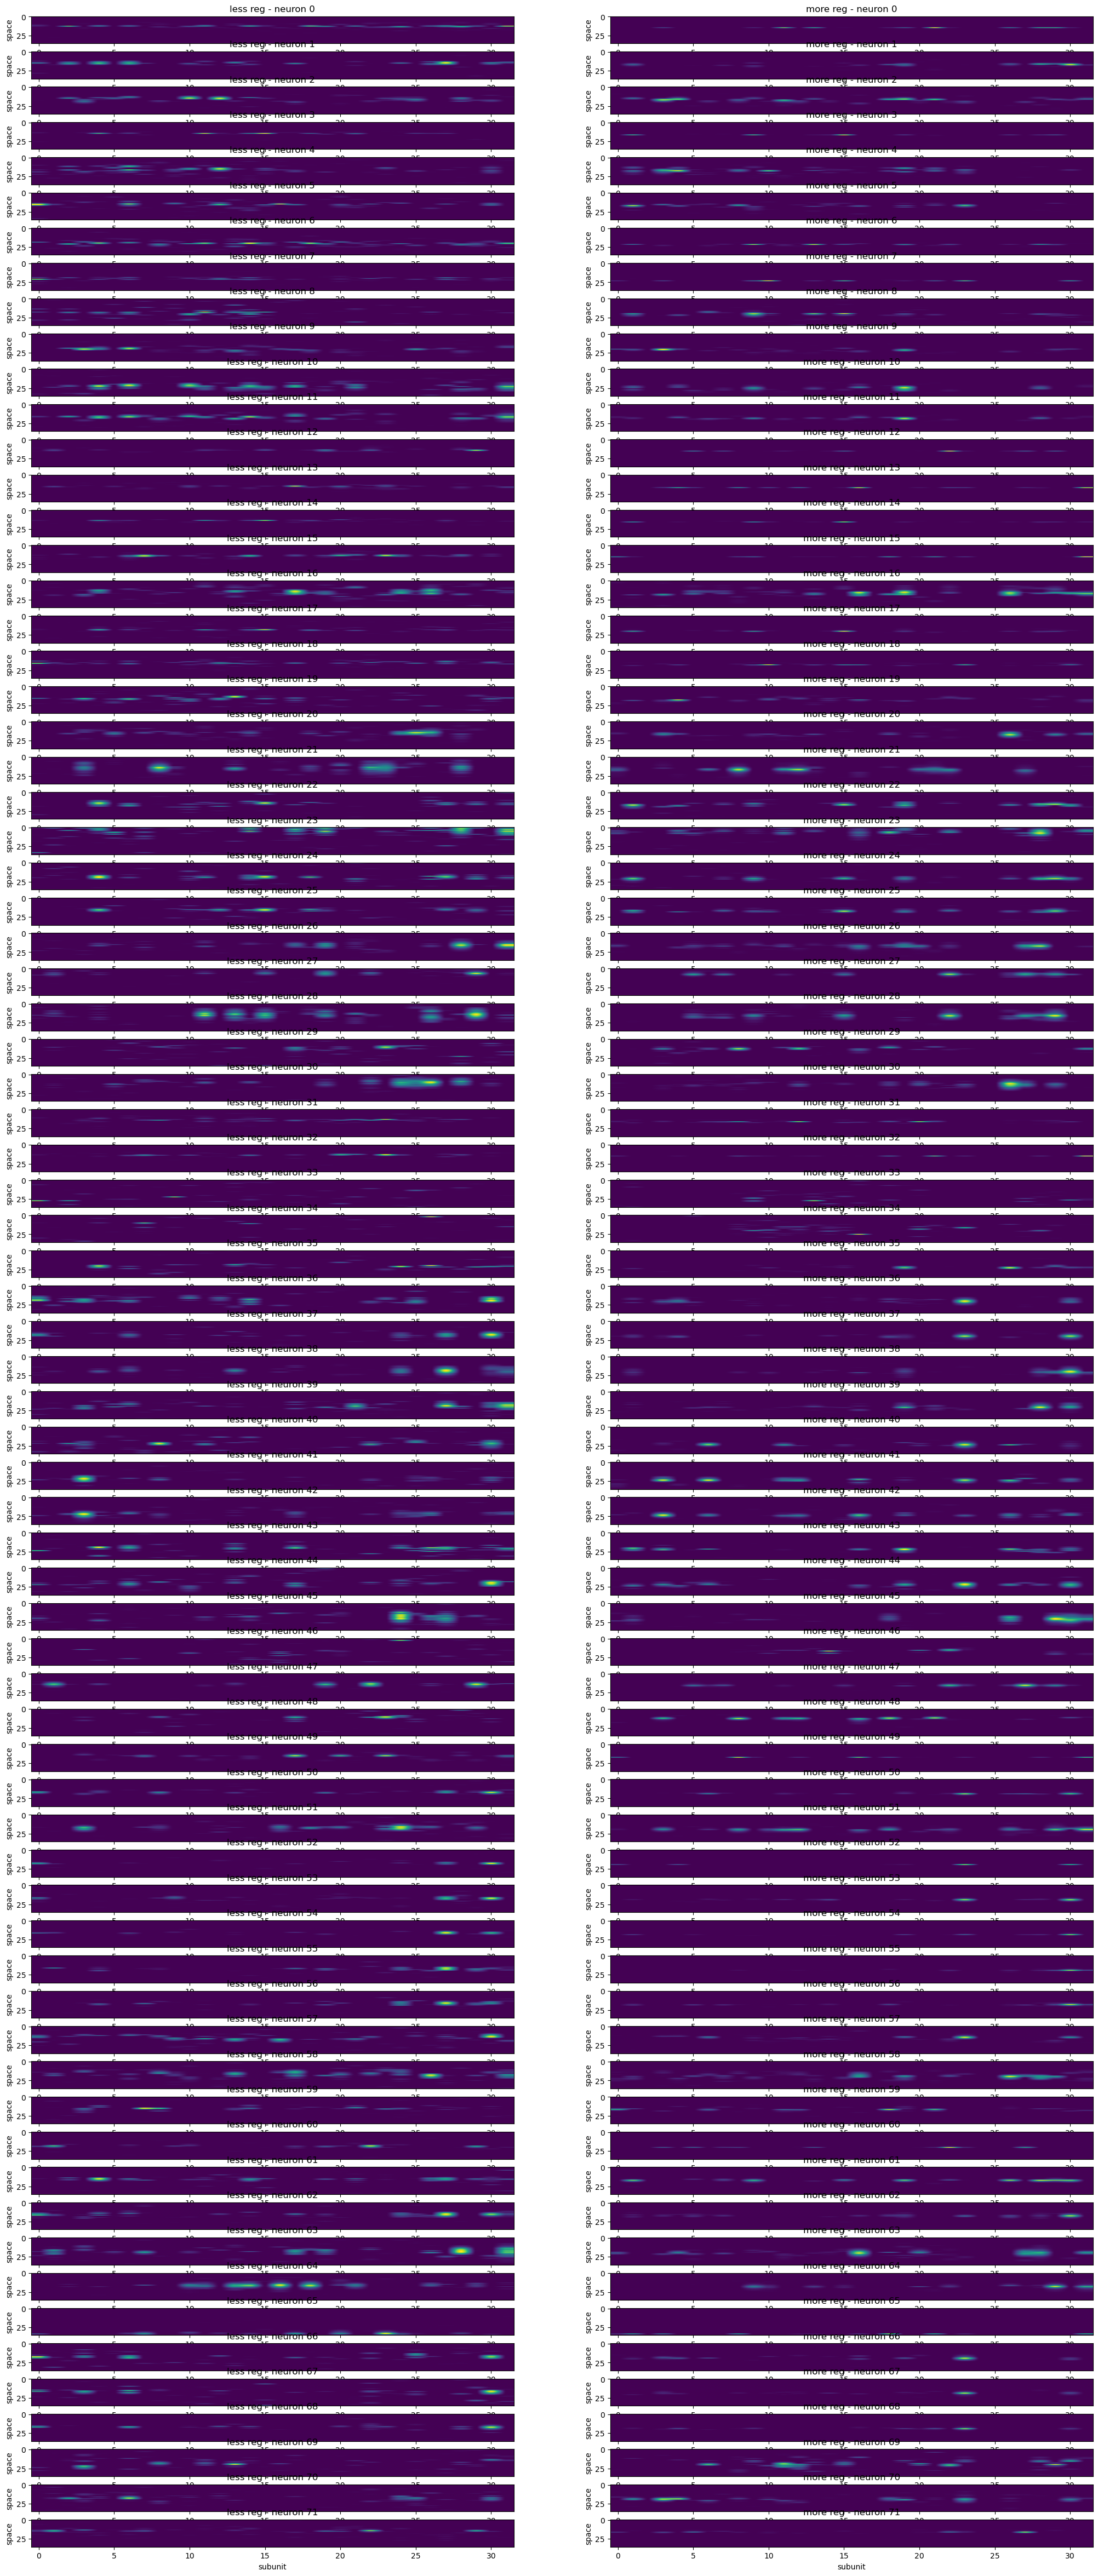

In [11]:
# plot readout weights for trial_less_reg and trial_more_reg side by side in columns for each of 11 neurons
# make a grid
fig, axs = plt.subplots(72, 2, figsize=(25, 60))
# put vertical space between the plots
fig.subplots_adjust(hspace=0.3)
for i in range(72):
    # plot the weights for each trial
    axs[i,0].imshow(trial_less_reg.model.networks_by_name['readout'].layers[0].weights[:,:,i].T, aspect='auto')
    axs[i,1].imshow(trial_more_reg.model.networks_by_name['readout'].layers[0].weights[:,:,i].T, aspect='auto')
    # set the title
    axs[i,0].set_title('less reg - neuron ' + str(i))
    axs[i,1].set_title('more reg - neuron ' + str(i))
    # set the y axis label
    axs[i,0].set_ylabel('space')
    
    axs[i,1].set_ylabel('space')
    # set the x axis label
    axs[i,0].set_xlabel('subunit')
    axs[i,1].set_xlabel('subunit')

In [12]:
trial_less_reg.model.networks_by_name['readout'].layers[0].weights.shape

(32, 36, 72)

# plot readout weights for trial_less_reg and trial_more_reg on the same plot

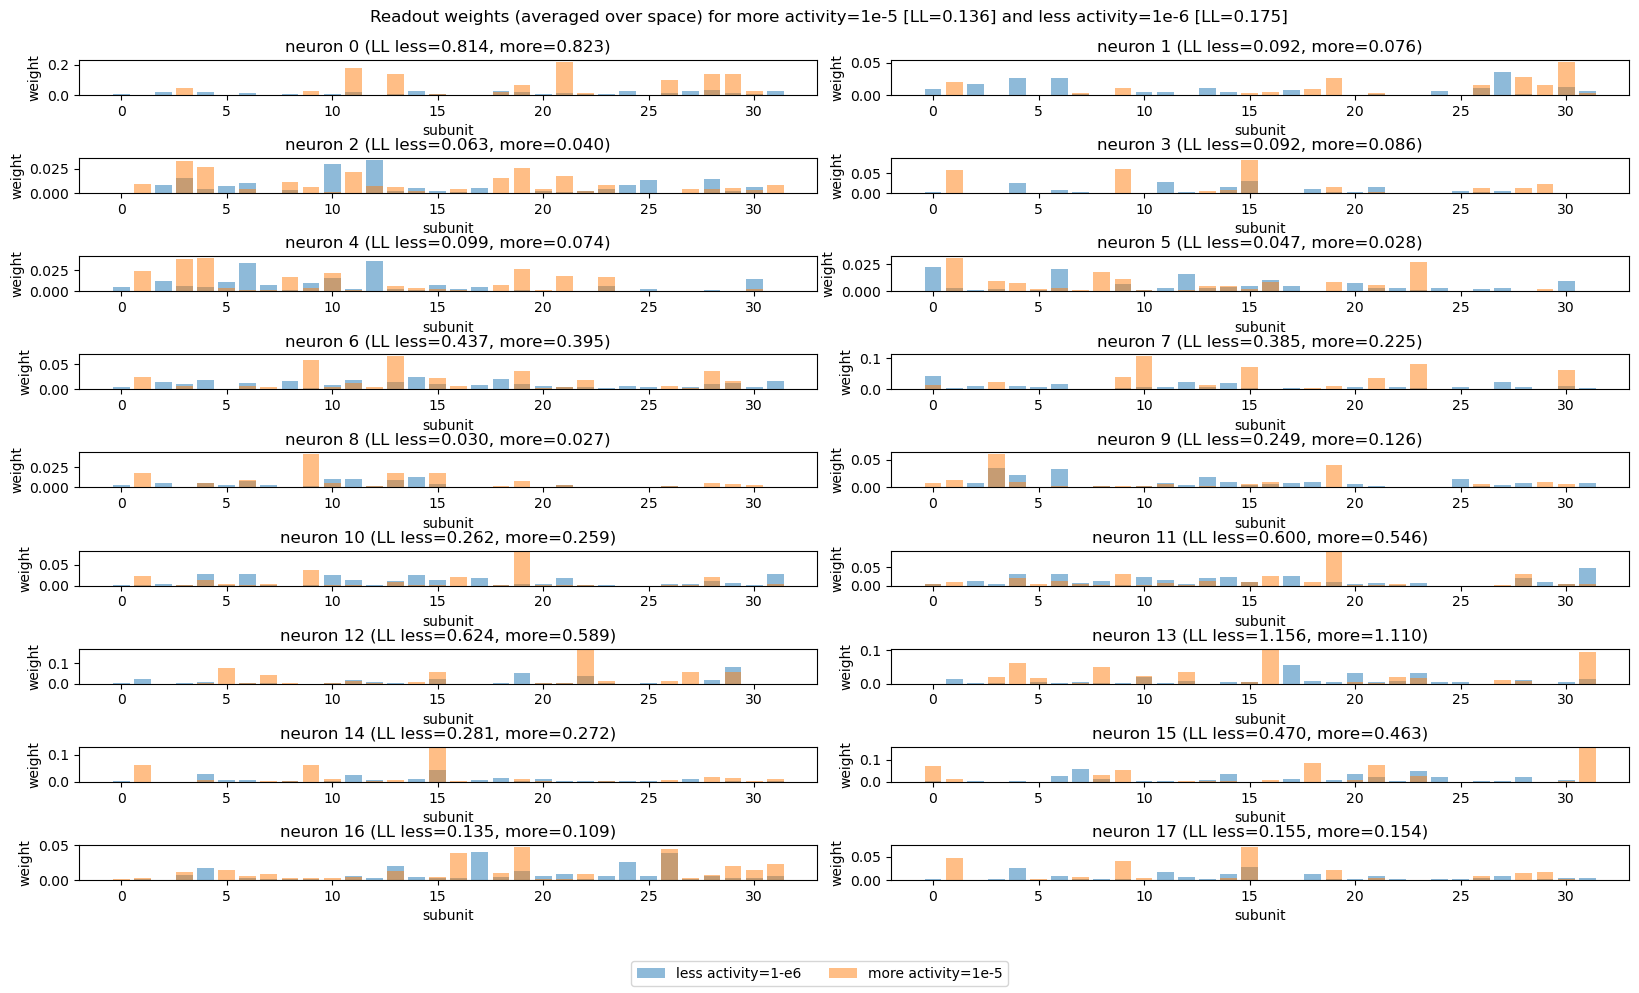

In [13]:
# plot readout weights for trial_less_reg and trial_more_reg on the same plot for each of 36 neurons
# make a grid
fig, axs = plt.subplots(9, 2, figsize=(20, 10))
# put vertical and horizontal space between the plots
fig.subplots_adjust(hspace=1.8, wspace=0.1, top=0.93)
# add a title to the entire figure
# calculate the mean LL over each trial
trial_less_reg_meanLL = np.mean(trial_less_reg.LLs)
trial_more_reg_meanLL = np.mean(trial_more_reg.LLs)
fig.suptitle('Readout weights (averaged over space) for more activity=1e-5 [LL='+'{:.3f}'.format(trial_more_reg_meanLL) +'] and less activity=1e-6 [LL='+'{:.3f}'.format(trial_less_reg_meanLL) +']')
h1, h2 = None, None
labels = None
for i, neuron in enumerate(range(0,18)):
    # average over space
    less_reg_weights = trial_less_reg.model.networks_by_name['readout'].layers[0].weights.mean(axis=1)[:,neuron]
    more_reg_weights = trial_more_reg.model.networks_by_name['readout'].layers[0].weights.mean(axis=1)[:,neuron]
    # plot the weights for each trial
    h1 = axs[i//2, i%2].bar(range(len(less_reg_weights)), less_reg_weights, label='less reg', alpha=0.5)
    h2 = axs[i//2, i%2].bar(range(len(more_reg_weights)), more_reg_weights, label='more reg', alpha=0.5)
    # set the title
    axs[i//2, i%2].set_title('neuron ' + str(neuron) + ' (LL less=' + '{:.3f}'.format(trial_less_reg.LLs[neuron])+', more=' + '{:.3f}'.format(trial_more_reg.LLs[neuron])+')')
    # set the y axis label
    axs[i//2, i%2].set_ylabel('weight')
    # set the x axis label
    axs[i//2, i%2].set_xlabel('subunit')
fig.legend([h1, h2], ['less activity=1-e6', 'more activity=1e-5'], loc='lower center', ncol=2)

# look at the activations for each neuron

In [39]:
start = 0
end = 2

# get the activations
results_less_reg = predict.predict(trial_less_reg.model,
                                   dataset=trial_less_reg.dataset[start:end],
                                   network_names_to_use=['core', 'readout'],
                                   calc_jacobian=False)

# results_more_reg = predict.predict(trial_more_reg.model,
#                                    dataset=trial_more_reg.dataset[start:end],
#                                    network_names_to_use=['core', 'readout'],
#                                    calc_jacobian=True)
results_less_reg.outputs[0]['readout'][0].shape

(1, 72)

In [28]:
# results outputs is [frame, network, layer, unit]
results_less_reg.outputs[0]['core'][0].shape

array([[ 0.        ,  0.06157188,  0.019115  ,  0.        ,  0.        ,
         0.1469089 ,  0.0256177 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.03245718,
         0.18578435,  0.        ,  0.32207146,  0.        ,  0.        ,
         0.1598581 ,  0.        ,  0.00900442,  0.        ,  0.        ,
         0.12346017,  0.12304296,  0.06849281,  0.        ,  0.6376883 ,
         0.        ,  0.        ,  0.32832432,  0.29816672,  0.        ,
         0.        ,  0.43696707,  0.4612764 ,  0.38978288,  0.29064932,
         0.        ,  0.        ,  0.01524967,  0.09310543,  0.        ,
         0.        ,  0.        ,  0.2930281 ,  0.37083918,  0.16516821,
         0.        ,  0.        ,  0.        ,  0.07292487,  0.01385397,
         0.07762654,  0.        ,  0.        ,  0.15307897,  0.01059645,
         0.13066414,  0.18767174,  0.        ,  0.        ,  0.        ,
         0.09836963,  0.25675848,  0.01043974,  0. 

TypeError: 'Results' object is not subscriptable

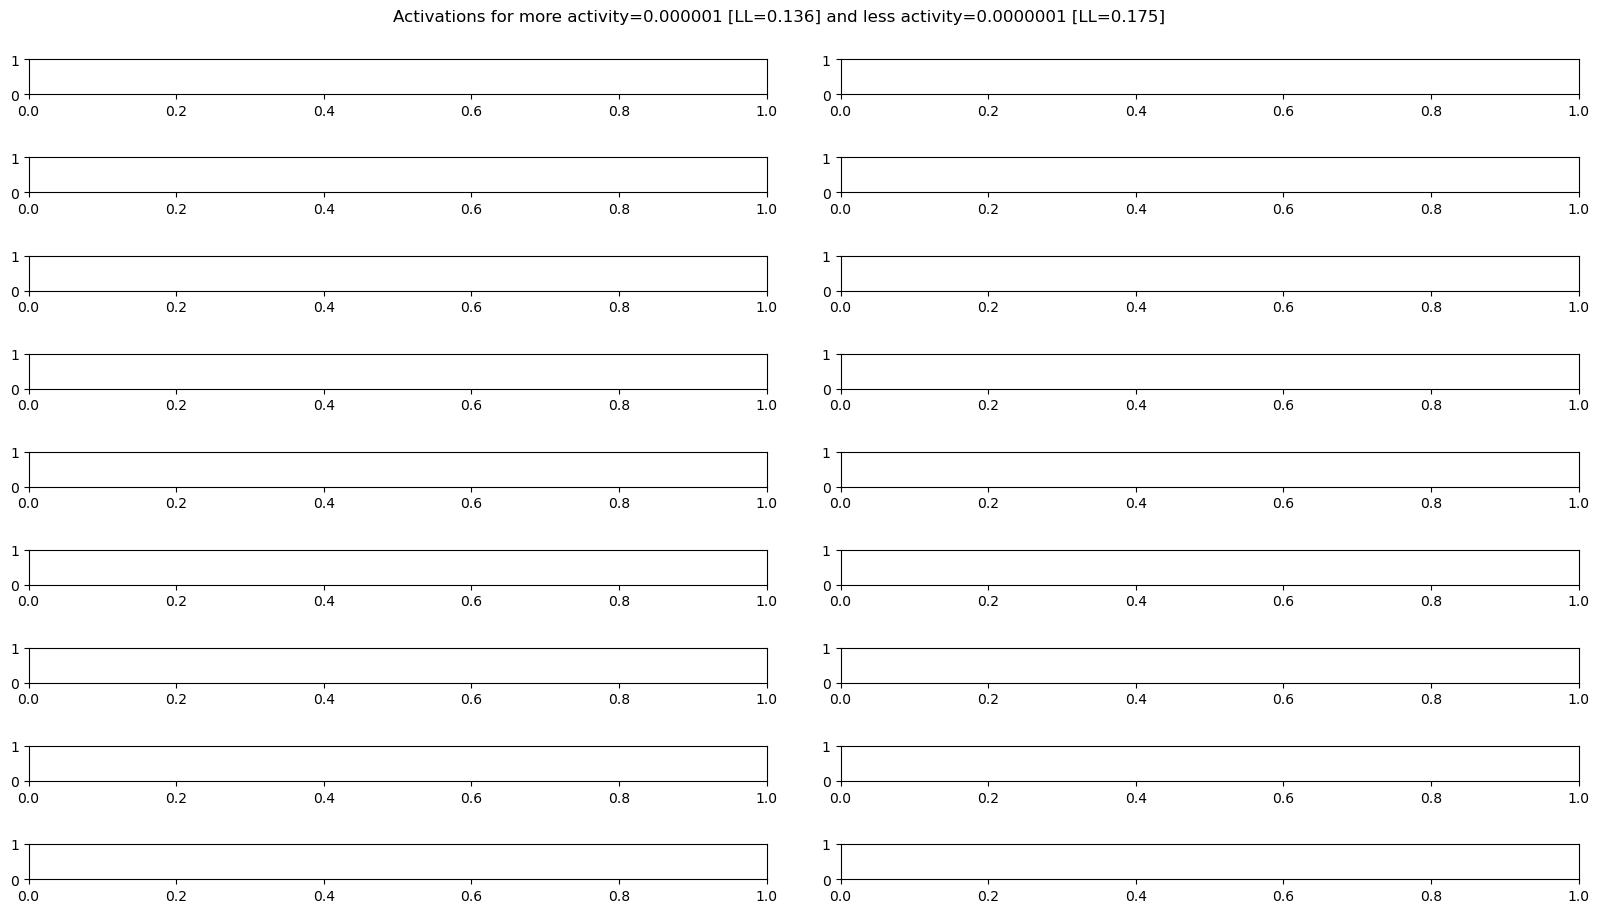

In [15]:
# plot the activations for each neuron
# make a grid
fig, axs = plt.subplots(9, 2, figsize=(20, 10))
# put vertical and horizontal space between the plots
fig.subplots_adjust(hspace=1.8, wspace=0.1, top=0.93)
# add a title to the entire figure
# calculate the mean LL over each trial
trial_less_reg_meanLL = np.mean(trial_less_reg.LLs)
trial_more_reg_meanLL = np.mean(trial_more_reg.LLs)
fig.suptitle('Activations for more activity=0.000001 [LL='+'{:.3f}'.format(trial_more_reg_meanLL) +'] and less activity=0.0000001 [LL='+'{:.3f}'.format(trial_less_reg_meanLL) +']')
h1, h2 = None, None
labels = None

for i, neuron in enumerate(range(0,18)):
    # average over space
    less_reg_activations = results_less_reg['core']['a'][:,neuron]
    more_reg_activations = results_more_reg['core']['a'][:,neuron]
    # plot the weights for each trial
    h1 = axs[i//2, i%2].plot(less_reg_activations, label='less reg', alpha=0.5)
    h2 = axs[i//2, i%2].plot(more_reg_activations, label='more reg', alpha=0.5)
    # set the title
    axs[i//2, i%2].set_title('neuron ' + str(neuron) + ' (LL less=' + '{:.3f}'.format(trial_less_reg.LLs[neuron])+', more=' + '{:.3f}'.format(trial_more_reg.LLs[neuron])+')')
    # set the y axis label
    axs[i//2, i%2].set_ylabel('activation')
    # set the x axis label
    axs[i//2, i%2].set_xlabel('time')
    
fig.legend([h1, h2], ['less activity=0.0000001', 'more activity=0.000001'], loc='lower center', ncol=2)